In [1]:
import pandas as pd
import os.path as osp
import numpy as np
import networkx as nx


import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from scipy.sparse.csgraph import shortest_path

from torch_geometric.utils import (negative_sampling, to_dense_adj, dense_to_sparse, 
                                   from_scipy_sparse_matrix, remove_self_loops)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv
from torch_geometric.data import Data, InMemoryDataset, DataLoader, Data, download_url
from torch_geometric.utils import (negative_sampling, add_self_loops,
                                   train_test_split_edges, k_hop_subgraph,
                                   to_scipy_sparse_matrix, from_networkx)


from typing import Optional, Callable

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# pandas로 불러오기

In [12]:
# data = pd.read_excel('Mers_contact.xls', names=['source', 'target'])#, index_col=None, header=None)
data = pd.read_csv('Mers_contact.csv', names=['source', 'target'])#, index_col=None, header=None)   

In [13]:
df=pd.DataFrame(data['source'].str.split('_').tolist(), columns=['s_arr','source'])
df0=data['target'].str.replace('#', '_')
df1=pd.DataFrame(df0.str.split('_').tolist(), columns=['t_arr', 'target'])
df['t_arr']=df1['t_arr']
df['target']=df1['target']

In [16]:
df = df.drop(0)

# Networkx 이용 G_infection 생성

In [17]:
df_infection = df[df['t_arr'] == 'M']

In [18]:
df_infection

,s_arr,source,t_arr,target
26,M,001,M,027
40,M,001,M,009
50,M,001,M,042
84,M,001,M,025
85,M,001,M,018
...,...,...,...,...
21231,M,170,M,176
29367,M,119,M,163
29552,M,132,M,179
30010,M,184,M,067


In [19]:
G_infection = nx.from_pandas_edgelist(df_infection, 'source', 'target')

In [20]:
print(nx.info(G_infection))

Graph with 186 nodes and 183 edges


In [21]:
# compute centrality and degree
centrality = nx.betweenness_centrality(G_infection, k=10, endpoints=True)
d = dict(G_infection.degree)

# compute community structure
lpc = nx.community.label_propagation_communities(G_infection)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

In [22]:
len(community_index)

186

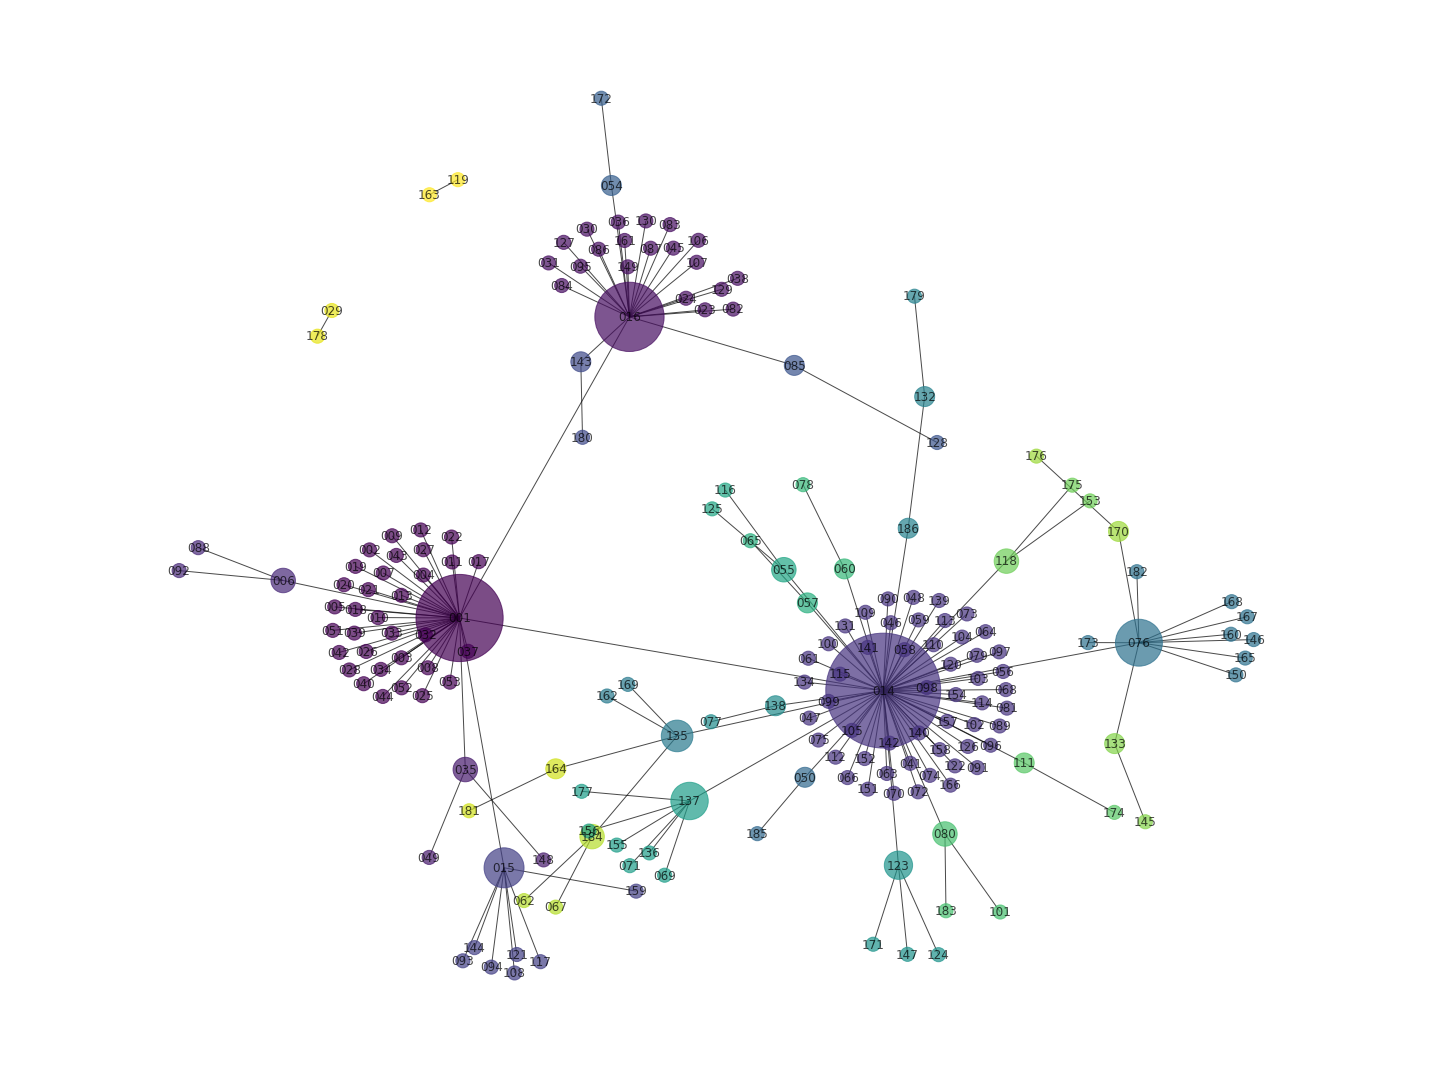

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(G_infection, k=0.15, seed=4572321)
node_color = [community_index[n] for n in G_infection]
#node_size = [v * 20000 for v in centrality.values()]
node_size=[v * 200 for v in d.values()]
nx.draw_networkx(
    G_infection,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    #edge_color="gainsboro",
    alpha=0.7,
)
# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

## Node feature 추가

In [25]:
c = list(community_index.values())
b = list(nx.betweenness_centrality(G_infection).values())

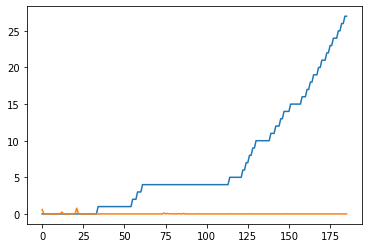

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(186), c)
plt.plot(range(186), b)
plt.show()

In [27]:
#nx.set_node_attributes(G_infection, pd.Series(e, index=G_infection.nodes).to_dict(), 'e')
nx.set_node_attributes(G_infection, pd.Series(b, index=G_infection.nodes).to_dict(), 'b')
nx.set_node_attributes(G_infection, pd.Series(c, index=G_infection.nodes).to_dict(), 'c')

## PyG 그래프로 변환 후 Numpy 파일로 저장

In [28]:
data_infection = from_networkx(G_infection)
data_infection

Data(edge_index=[2, 366], b=[186], c=[186], num_nodes=186)

In [29]:
n_comm = np.max(data_infection.c.numpy()) + 1
comm = np.eye(n_comm)[data_infection.c]

x = np.hstack((data_infection.b.numpy().reshape((-1, 1)), comm))
x.shape

(186, 29)

In [30]:
np.savez('Mers_infection.npz', edge_index=data_infection.edge_index.numpy(), x=x)

# Contact Graph (full) 생성

In [31]:
G = nx.from_pandas_edgelist(df, 'source', 'target', create_using=nx.Graph())

In [32]:
print(nx.info(G))

Graph with 33095 nodes and 33090 edges


## Node label 추가

In [33]:
colors = []
node_label = []

for node in G:
    if node.startswith('M'):
        colors.append("red")
        node_label.append(1)
    else: 
        colors.append("green")
        node_label.append(0)

In [34]:
# compute centrality and degree
centrality_full = nx.betweenness_centrality(G, k=10, endpoints=True)
d_full = dict(G.degree)

# compute community structure
lpc_full = nx.community.label_propagation_communities(G)
community_index_full = {n: i for i, com in enumerate(lpc_full) for n in com}

In [35]:
c = list(community_index_full.values())
d = list(d_full.values())
#b = list(nx.betweenness_centrality(G).values())

In [36]:
nx.set_node_attributes(G, pd.Series(node_label, index=G.nodes).to_dict(), 'l')
nx.set_node_attributes(G, pd.Series(d, index=G.nodes).to_dict(), 'd')
nx.set_node_attributes(G, pd.Series(c, index=G.nodes).to_dict(), 'c')

KeyError: '20003720'

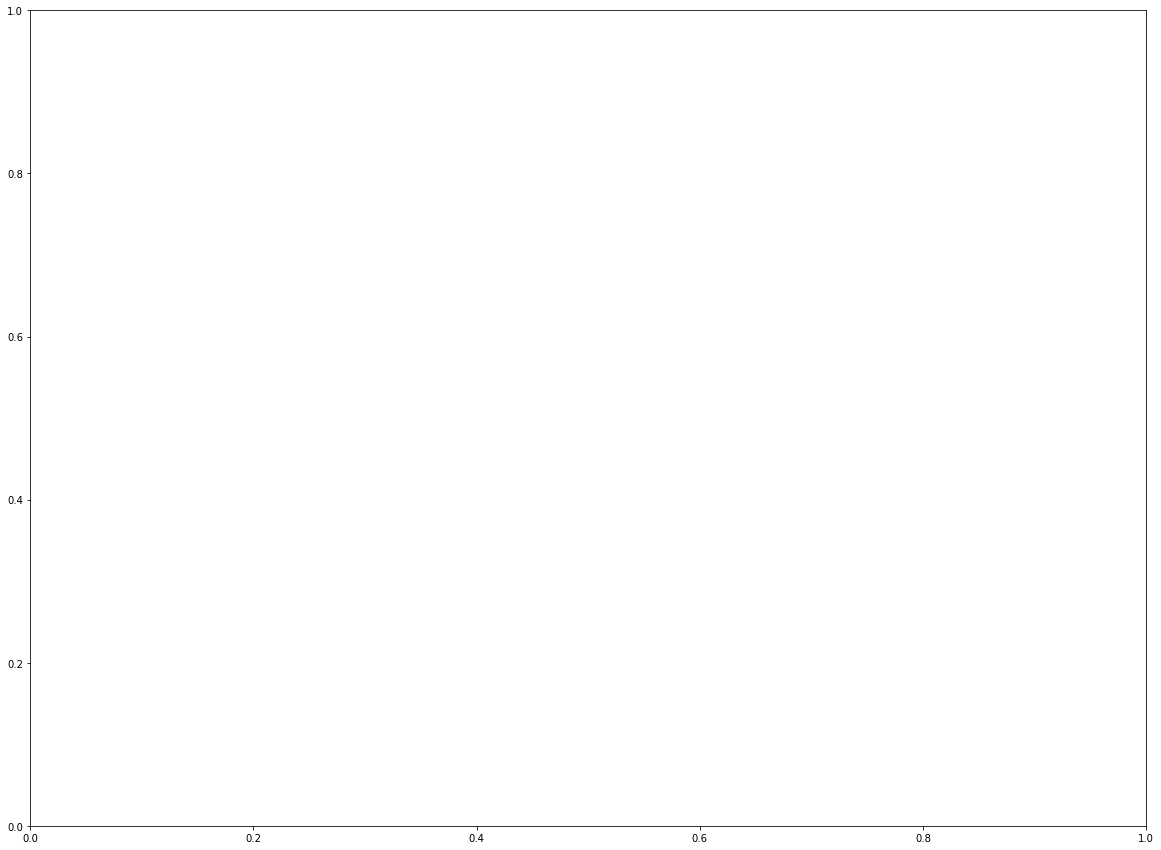

In [37]:
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(G, k=0.15, seed=4572321)
node_color = [community_index[n] for n in G]
#node_size = [v * 20000 for v in centrality.values()]
node_size=[v * 20 for v in d_full.values()]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=node_color,
    node_size=node_size,
    #edge_color="gainsboro",
    alpha=0.7,
)
# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

## Netwokx 그래프를 PyG 그래프로 변경 후 Numpy 파일로 저장

In [ ]:
data_full = from_networkx(G)
data_full

Data(c=[33095], d=[33095], edge_index=[2, 66180], l=[33095])

In [ ]:
n_comm_full = np.max(data_full.c.numpy()) + 1
comm_full = np.eye(n_comm_full)[data_full.c]

x = np.hstack((data_full.l.numpy().reshape((-1, 1)),data_full.d.numpy().reshape((-1, 1)), comm_full))
x.shape

(33095, 161)

In [ ]:
np.savez('Mers_contact.npz', edge_index=data_full.edge_index.numpy(), x=x)